In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
#mpl.rcParams['image.cmap'] = 'jet'
import numpy as np
import time, sys

MEGCNN Group Meeting 08.12.17
---------------------------------

**NeuCiS (Neural Circuit Simulator) - A new python framework for neural mass modeling**
==============================================

*Developed by Richard & Daniel, based on previous work of Thomas and friends*

Overview
---------

**1. Neural Mass Model Recap**
    - Basic formalism
    - Jansen-Rit model of a canonical cortical column
**2. NeuCiS Structure**
    - Axon
    - Synapse
    - Population
    - Circuit
**3. NeuCis Example Simulations**
    - Jansen-Rit model bifurcation
    - Resting-state functional connectivity estimation
**4. Outlook**
    - Future features
    - Massively parallel computing via Garchingen

1. Neural Mass Model Recap - Basic formalism
--------------------------------------------

* Mesoscopic description of interactions between large neural populations
* Mean-field approximation of sub-threshold dynamcis of LIF neuron
* Population states described by average membrane potentials
* Population interactions realized via average firing rates

1. Neural Mass Model Recap - Jansen-Rit model of a canonical microcircuit
-------------------------------------------------------------------------

<img src="./img/JR_circuit.png" alt="R circuit" style="width: 600px;"/>

2. NeuCiS Structure
-------------------
Jansen Rit Circuit                     | Modular Framework representation
---------------------------------------|----------------------------------------------
<img src="./img/JR_circuit_reduced.png" alt="reduced JR circuit" style="width: 320px;"/>  | <img src="./img/program_structure.svg.png" alt="Program structure" style="width: 500px;"/> 

2. NeuCiS Structure - Axon
--------------------------

* Represents average behavior of generic axon hillok.
* Can compute average firing rate from average membrane potential
* ...given an axonal transfer function, which has to be provided

Base Axon - An example
-------------------------

**Axon parameters**

In [2]:
def transfer_function(membrane_potential: float) -> float:
    """Axon function transforming membrane potentials into firing rates.
    
    Parameters
    ----------
    membrane_potential
        Average membrane potential at axon hillok [unit = V].
    
    Returns
    -------
    float
        Average firing rate at axon hillok [unit = 1/s].
    """
    return np.exp(-membrane_potential)

**Axon initialization**

In [3]:
cd ..

/home/rgast/Documents/GitRepo/CBSMPG/BrainNetworks


In [4]:
from core.axon import Axon

exponential_axon = Axon(transfer_function)

**Calculate average firing rate from average membrane potential of -75 mV**

In [5]:
firing_rate = exponential_axon.compute_firing_rate(-0.075)

print('Firing rate: ',firing_rate,' Hz.')

Firing rate:  1.07788415088  Hz.


**Plot axon transfer function**

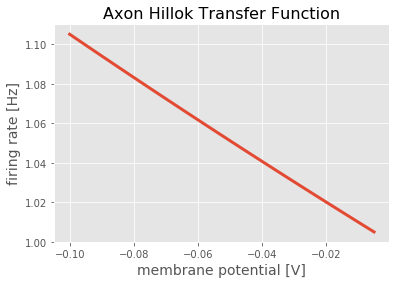

In [6]:
membrane_potentials = np.arange(-0.1, 0.0, 0.005)

fig = exponential_axon.plot_transfer_function(membrane_potentials, 
                                              create_plot=False)

SigmoidAxon(Axon)
-------------------

* Sub-class of axon
* Uses parametrized sigmoid as transfer function

**Sigmoid axon parameters**

In [7]:
max_fr = 2.0             # maximum firing rate in Hz
potential_thresh = -0.07 # membrane potential threshold in V
steepness = 300.         # steepness of the sigmoidal transfer function in Hz

**Sigmoid axon initialization**

In [8]:
from core.axon import SigmoidAxon

sigmoid_axon = SigmoidAxon(max_fr, potential_thresh, steepness)

**Plot sigmoid axon transfer function**

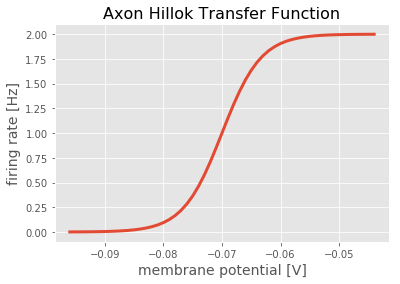

In [9]:
fig = sigmoid_axon.plot_transfer_function(create_plot=False, epsilon=1e-3)

**JansenRitAxon(SigmoidAxon) - A default parametrization of the sigmoid axon**

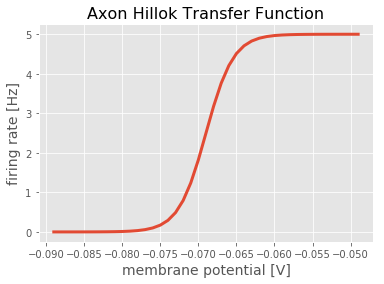

In [10]:
from core.axon import JansenRitAxon

jansenrit_axon = JansenRitAxon()

fig = jansenrit_axon.plot_transfer_function(create_plot=False)

2. NeuCiS Structure - Synapse
-----------------------------

* Represents average behavior of a generic post-synapse of a population.
* Can transform incoming pre-synaptic firing rates into post-synaptic membrane potential changes
* ...given a synaptic kernel function

Base Synapse - An example
-----------------------------

**Synapse parameters**

In [11]:
def kernel_function(time: float) -> float:
    """Synapse function transforming incoming firing rates into membrane 
    potential changes.
    
    Parameters
    ----------
    time
        Time-point at which to evaluate synaptic kernel [unit = s].
        
    Returns
    -------
    float
        synaptic kernel value at time [unit = A].
    """
    return np.exp(-time)

efficacy = 1e-12   # synaptic efficacy in amper
bin_size = 1e-4    # step-size between synaptic kernel bins in seconds
max_delay = 0.05   # maximum time [s] after which input still affects synapse

**Synapse initialization**

In [12]:
from core.synapse import Synapse

exponential_synapse = Synapse(kernel_function, efficacy, bin_size, max_delay)

**Calculate average synaptic current for incoming pre-synaptic firing rate of 100 Hz**

In [13]:
fr = np.ones(100)*100. # 100 Hz pre-synaptic firing rate input
synaptic_current = exponential_synapse.get_synaptic_current(fr)

print('Synaptic current: ', synaptic_current,' A.')

Synaptic current:  9.85017125887e-13  A.


**Plot synaptic kernel**

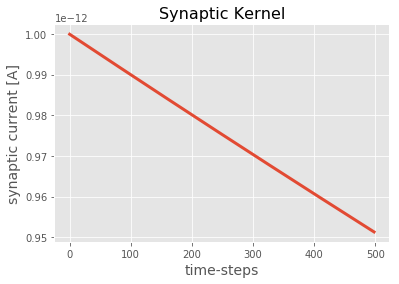

In [14]:
fig = exponential_synapse.plot_synaptic_kernel(create_plot=False)

DoubleExponentialSynapse(Synapse)
--------------------------------------

* Sub-class of synapse
* Uses parametrized double-exponential function for synaptic kernel

**Double-exponential synapse parameters**

In [15]:
tau_rise = 0.005   # rise time of the synaptic kernel in seconds
tau_decay = 0.05   # decay time of the synaptic kernel in seconds
efficacy = 1e-12   # synaptic efficacy in amper
bin_size = 1e-4    # step-size between synaptic kernel bins in seconds
max_delay = 0.1    # maximum time [s] after which input still affects synapse

**Double-exponential synapse initialization**

In [16]:
from core.synapse import DoubleExponentialSynapse

double_exponential_synapse = DoubleExponentialSynapse(efficacy=efficacy, 
                                                      tau_decay=tau_decay, 
                                                      tau_rise=tau_rise, 
                                                      bin_size=bin_size, 
                                                      max_delay=max_delay)

**Plot double-exponential synaptic kernel**

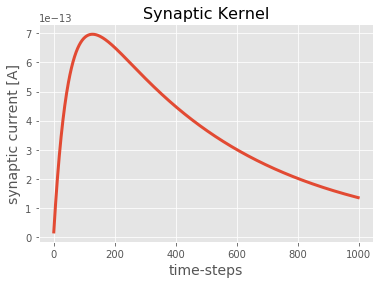

In [17]:
fig = double_exponential_synapse.plot_synaptic_kernel(create_plot=False)

**GABAACurrentSynapse(DoubleExponentialSynapse) - A default parametrization of the double-exponential synapse**

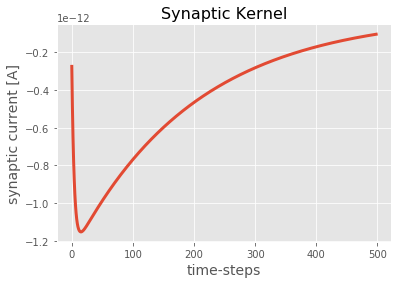

In [18]:
from core.synapse import GABAACurrentSynapse

gabaa_synapse = GABAACurrentSynapse(bin_size=1e-4, max_delay=0.05)

fig = gabaa_synapse.plot_synaptic_kernel(create_plot=False)

2. NeuCiS Structure - Population
--------------------------------

* Defined via a number of synapses and an axon
* Can be initialized via synapse/axon parameters or templates
* Central unit of NeuCis framework

Base Population - An Example
--------------------------------

**Population parameters**

In [19]:
synapses = ['AMPACurrentSynapse', 'GABAACurrentSynapse']

axon_params = {'max_firing_rate': 3.,
               'membrane_potential_threshold': -0.069,
               'sigmoid_steepness': 432.10}

step_size = 5e-4                                            # in s
init_state = -0.075                                         # in V
max_synaptic_delay = 0.1                                    # in s
store_state_variables = True

**Population initialization**

In [20]:
from core.population import Population

population = Population(synapses=synapses, 
                        axon_params=axon_params, 
                        step_size=step_size, 
                        init_state=init_state,
                        max_synaptic_delay=max_synaptic_delay, 
                        store_state_variables=store_state_variables)

**Update state of the population given synaptic input of 200 Hz to AMPA/GABAA synapse.**

In [21]:
firing_rates = np.zeros(200)

# 1) apply step-function input to AMPA synapse
population.synaptic_input[population.current_input_idx, 0] = 200. 

# 2) make 100 subsequent state-updates
for i in range(100):
    population.state_update() 
    firing_rates[i] = population.get_firing_rate()

# 3) apply step-function input to GABAA synapse
population.synaptic_input[population.current_input_idx, 1] = 200.

# 4) make 100 subsequent state-updates
for i in range(100,200):
    population.state_update()
    firing_rates[i] = population.get_firing_rate()

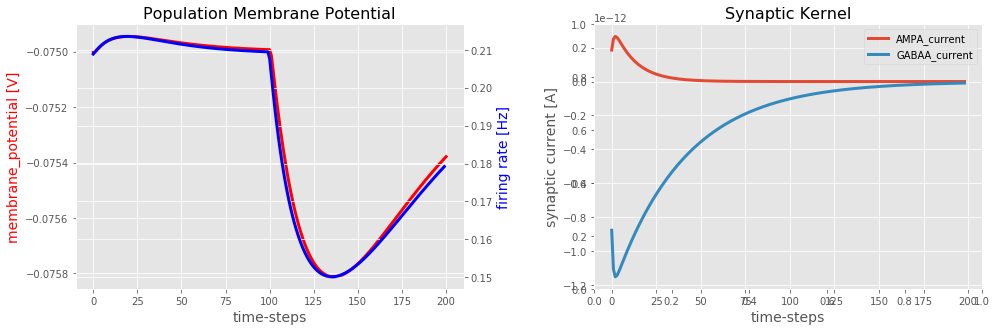

In [22]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

# plot membrane potentials
ax1 = axes[0]
ax1.plot(np.array(population.state_variables), 'r')
ax1.set_title('Population Membrane Potential')
ax1.set_xlabel('time-steps')
ax1.set_ylabel('membrane_potential [V]', color='r')

# plot firing rates
ax2 = ax1.twinx()
ax2.plot(firing_rates, 'b')
ax2.set_ylabel('firing rate [Hz]', color='b')

# plot synaptic kernels
ax3 = axes[1]
ax3 = fig.add_subplot(122)
ax3 = population.plot_synaptic_kernels(create_plot=False, axes=ax3)
plt.tight_layout()

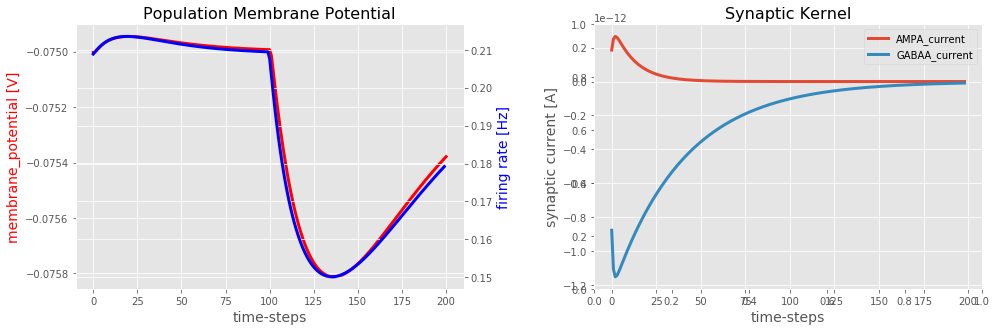

In [23]:
fig

**Default population parametrizations**

In [24]:
from core.population import JansenRitPyramidalCells
from core.population import JansenRitInhibitoryInterneurons

JR_PCs = JansenRitPyramidalCells()
JR_IINs = JansenRitInhibitoryInterneurons()

Text(0.5,1,'Synaptic kernels of JR_IINs')

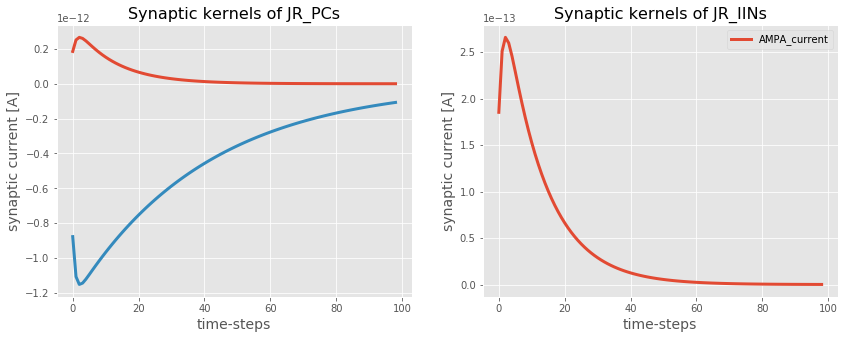

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

# plot post-synaptic kernels of pyramidal cells
ax1 = axes[0]
ax1 = JR_PCs.plot_synaptic_kernels(create_plot=False, axes=ax1)
ax1.set_title('Synaptic kernels of JR_PCs')

# plot post-synaptic kernel of inhibitory interneurons
ax2 = axes[1]
ax2 = JR_IINs.plot_synaptic_kernels(create_plot=False, axes=ax2)
ax2.set_title('Synaptic kernels of JR_IINs')

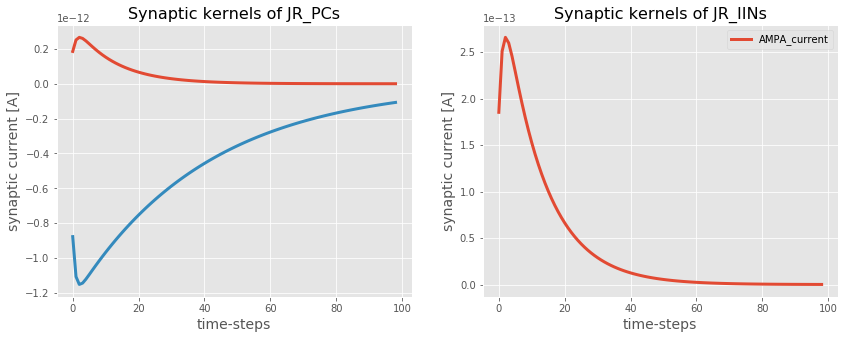

In [26]:
fig

2. NeuCiS Structure - Circuit
--------------------------------

* Allows to build delay-connected circuits of populations
* ...given a list of population instances plus a connecitvit matrix (minimum requirements)
* Involves a run function that simulates circuit behavior over time
* ...given a simulation time and synaptic input

Three Ways of Building a Circuit of Connected Populations
-----------------------------------------------------------------

- CircuitFromScratch: Specify synapse/axon information for each population
- CircuitFromPopulations: Specify type of each population
- CircuitFromCircuit: Combine population circuits into a larger circuit

CircuitFromScratch
--------------------

**Parameters**

In [27]:
connections = np.zeros((3, 3, 2))           # n_populations x n_populations 
                                            # x n_synapses

connections[:, :, 0] = [[0, 0.8 * 135, 0],  # AMPA connections (excitatory)
                        [1.0 * 135, 0, 0], 
                        [0.25 * 135, 0, 0]]

connections[:, :, 1] = [[0, 0, 0.25 * 135], # GABA-A connections (inhibitory)
                        [0, 0, 0], 
                        [0, 0, 0]]

synapses = ['AMPACurrentSynapse',           # for each synapse in network
            'GABAACurrentSynapse']

axons = ['JansenRitAxon',                   # for each population in network
         'JansenRitAxon', 
         'JansenRitAxon']                       

**Initialization**

In [28]:
from core.circuit import CircuitFromScratch

JR_circuit_1 = CircuitFromScratch(connections, 
                                  synapses=synapses, 
                                  axons=axons)

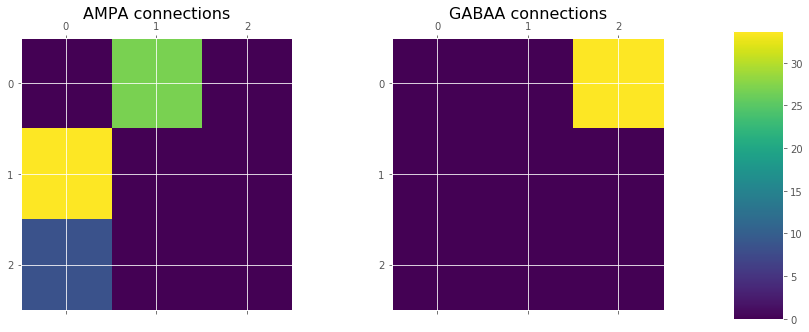

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# plot AMPA connections in circuit
ax1 = axes[0]
ax1.matshow(np.squeeze(JR_circuit_1.C[:,:,0]))
ax1.set_title('AMPA connections')

# plot GABAA connections in circuit
ax2 = axes[1]
mat = ax2.matshow(np.squeeze(JR_circuit_1.C[:,:,1]))
ax2.set_title('GABAA connections')

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(mat, cax=cbar_ax)

# collect synapses at each population
pc_synapses = [JR_circuit_1.populations[0].synapses[i].synapse_type for i in range(len(JR_circuit_1.populations[0].synapses))]
ein_synapses = [JR_circuit_1.populations[1].synapses[i].synapse_type for i in range(len(JR_circuit_1.populations[1].synapses))]
iin_synapses = [JR_circuit_1.populations[2].synapses[i].synapse_type for i in range(len(JR_circuit_1.populations[2].synapses))]

PC post-synapses:  ['AMPA_current', 'GABAA_current']
EIN post-synapses:  ['AMPA_current']
IIN post-synapses:  ['AMPA_current']


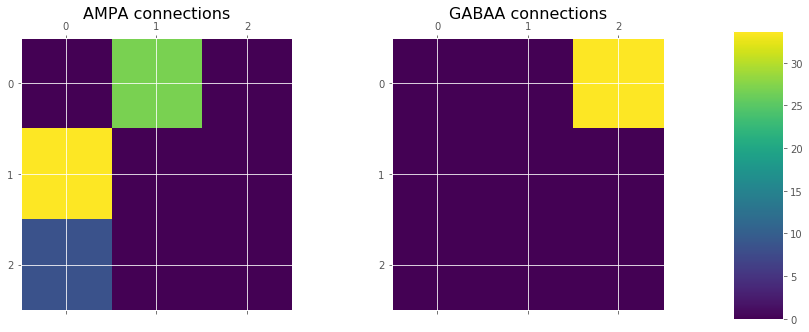

In [30]:
print('PC post-synapses: ',pc_synapses)
print('EIN post-synapses: ',ein_synapses)
print('IIN post-synapses: ',iin_synapses)
fig

CircuitFromPopulations
-------------------------

**Parameters**

In [31]:
connections = np.zeros((3, 3, 2))           # n_populations x n_populations 
                                            # x n_synapses
connections[:, :, 0] = [[0, 0.8 * 135, 0],  # AMPA connections (excitatory)
                        [1.0 * 135, 0, 0], 
                        [0.25 * 135, 0, 0]]

connections[:, :, 1] = [[0, 0, 0.25 * 135], # GABA-A connections (inhibitory)
                        [0, 0, 0], 
                        [0, 0, 0]]

populations = ['JansenRitPyramidalCells', 
               'JansenRitExcitatoryInterneurons', 
               'JansenRitInhibitoryInterneurons']

population_labels = ['JR_PCs', 'JR_EINs', 'JR_IINs']

**Initialization**

In [32]:
from core.circuit import CircuitFromPopulations

JR_circuit_2 = CircuitFromPopulations(population_types=populations, 
                                      connectivity=connections,
                                      population_labels=population_labels)

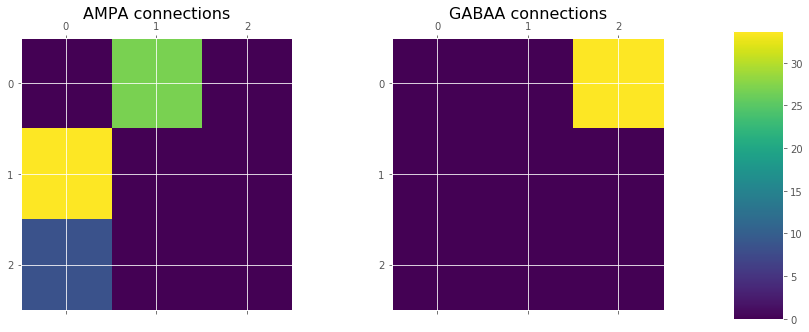

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# plot AMPA connections in circuit
ax1 = axes[0]
ax1.matshow(np.squeeze(JR_circuit_2.C[:,:,0]))
ax1.set_title('AMPA connections')

# plot GABAA connections in circuit
ax2 = axes[1]
mat = ax2.matshow(np.squeeze(JR_circuit_2.C[:,:,1]))
ax2.set_title('GABAA connections')

# plot colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.8])
fig.colorbar(mat, cax=cbar_ax)

# display post-synapses existing at each population
pc_synapses = [JR_circuit_2.populations[0].synapses[i].synapse_type for i in range(len(JR_circuit_2.populations[0].synapses))]
ein_synapses = [JR_circuit_2.populations[1].synapses[i].synapse_type for i in range(len(JR_circuit_2.populations[1].synapses))]
iin_synpses = [JR_circuit_2.populations[2].synapses[i].synapse_type for i in range(len(JR_circuit_2.populations[2].synapses))]

PC post-synapses:  ['AMPA_current', 'GABAA_current']
EIN post-synapses:  ['AMPA_current']
IIN post-synapses:  ['AMPA_current']


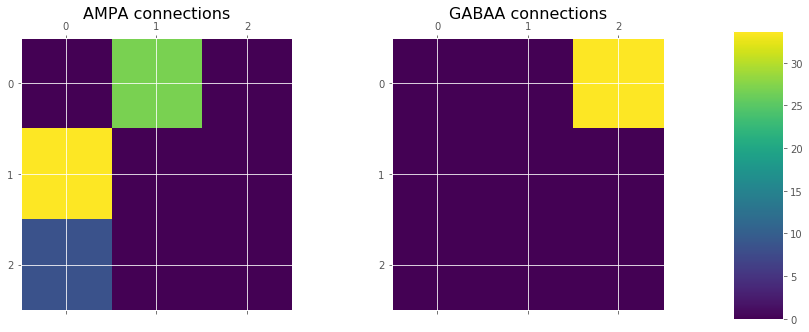

In [34]:
print('PC post-synapses: ', pc_synapses)
print('EIN post-synapses: ', ein_synapses)
print('IIN post-synapses: ', iin_synapses)
fig

**Simulating circuit behavior over time**

In [35]:
# simulation parameters
simulation_time = 1.                                            
synaptic_input = np.zeros((int(simulation_time/step_size), 3, 2)) 
synaptic_input[500:700, 0, 0] = 300.                            

# run simulations
JR_circuit_1.run(simulation_time=simulation_time, 
                 synaptic_inputs=synaptic_input)
JR_circuit_2.run(simulation_time=simulation_time, 
                 synaptic_inputs=synaptic_input)

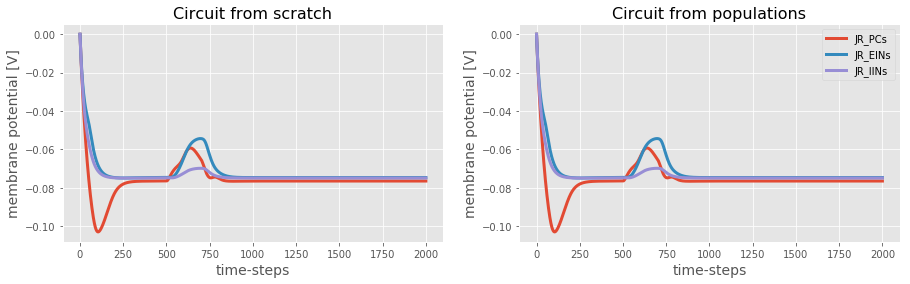

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# plot membrane potentials of jansen-rit circuit created from scratch
ax1 = axes[0]
ax1.set_title("Circuit from scratch")
JR_circuit_1.plot_population_states(create_plot=False, axes=ax1)

# plot membrane potentials of jansen-rit ciricuit created from population templates
ax2 = axes[1]
ax2.set_title("Circuit from populations")
JR_circuit_2.plot_population_states(create_plot=False, axes=ax2)

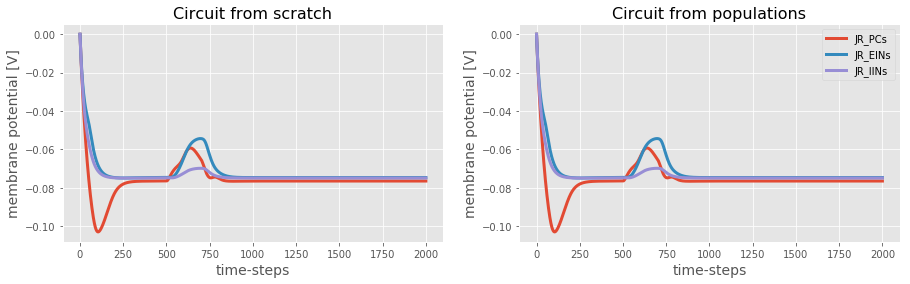

In [37]:
fig

3. NeuCis Example - Jansen-Rit model bifurcation
------------------------------------------------------

* Standard Jansen-Rit circuit fed with synaptic input to PCs
* Input: Stochastic gaussian input with constant variance and increasing mean

In [38]:
from core.circuit import JansenRitCircuit

synaptic_inputs = np.zeros((3, 2000, 3, 2))  # n_conditions x n_timesteps 
                                             # x n_populations x n_synapses
input_mean = [50., 100., 200.]               # different input conditions

JRCs = list()
for i in range(synaptic_inputs.shape[0]):
    
    # input definition
    synaptic_input = synaptic_inputs[i]
    synaptic_input[:, 0, 0] = 10 * np.random.randn(2000) + input_mean[i]
    
    # initialize and run
    JRC = JansenRitCircuit(step_size=5e-4)
    JRC.run(simulation_time=1., synaptic_inputs=synaptic_input)
    
    JRCs.append(JRC)

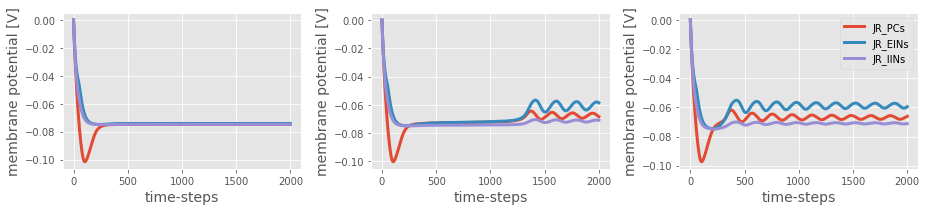

In [48]:
fig, axes = plt.subplots(1, synaptic_inputs.shape[0], figsize=(13,3))

for i,JRC in enumerate(JRCs):
    JRC.plot_population_states(create_plot=False, axes=axes[i])

plt.tight_layout()

3. NeuCis Example - Resting-state FC approximation
------------------------------------------------------

* 33 Jansen-Rit circuits connected as left-hemisphere network
* Input: Stochastic gaussian input to EINs of all circuits
* Pair-wise functional connectivity estimated from 1s simulation

In [40]:
from core.circuit import CircuitFromCircuit
from scipy.io import loadmat

N = 33                   # number of JR circuits
conn_scaling = 100.      # global scaling of connections
velocity = 2.            # information transmission velocity [m/s]

# simulation parameters
step_size = 5e-4
simulation_time = 1.
synaptic_input = np.random.randn(int(simulation_time/step_size), N*3, 2)
synaptic_input = 20 * synaptic_input + 200

# ciricuit parameters
circuits = [JansenRitCircuit(step_size=step_size) for i in range(N)]
Connectivity = np.zeros((N, N ,2))
Connectivity[:, :, 0] = loadmat('tests/SC')['SC'] * conn_scaling                
Delays = loadmat('tests/D')['D'] / velocity                         

# initialize and run
JRC = CircuitFromCircuit(circuits=circuits, 
                         connectivity=Connectivity, 
                         delays=Delays)
JRC.run(simulation_time=1., synaptic_inputs=synaptic_input)

In [41]:
# extract population states
states = JRC.get_population_states(state_variable_idx=0)
states = states[:, ::3]

# calculate covariance over populations
state_cov = states.T @ states

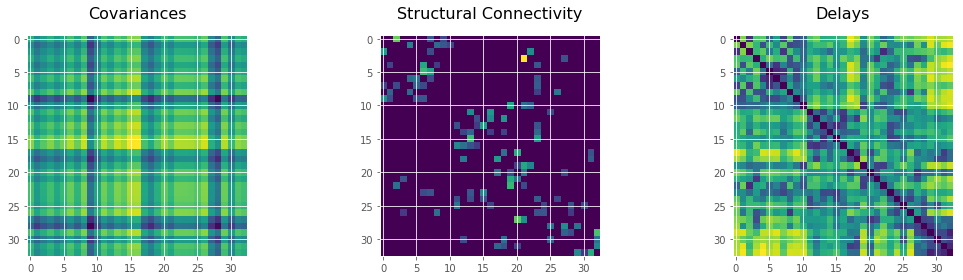

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

# plot covariance matrix
ax1 = axes[0]
ax1.matshow(state_cov)
ax1.xaxis.tick_bottom()
ax1.set_title('Covariances')

# plot structural connectivity matrix
ax2 = axes[1]
ax2.matshow(np.squeeze(Connectivity[:, :, 0]))
ax2.xaxis.tick_bottom()
ax2.set_title('Structural Connectivity')

# plot delay matrix
ax3 = axes[2]
ax3.matshow(Delays)
ax3.xaxis.tick_bottom()
ax3.set_title('Delays')

plt.tight_layout()

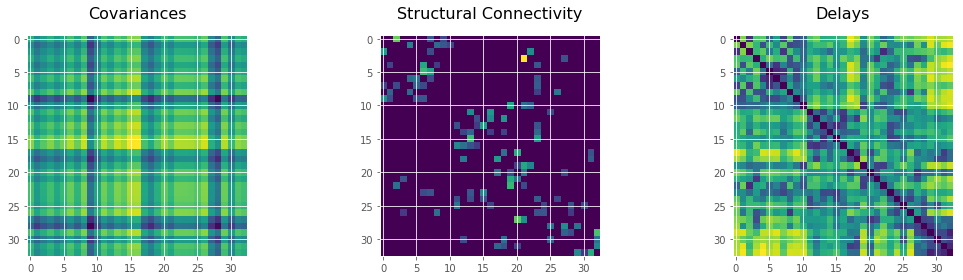

In [43]:
fig

4. Outlook - Future Features
----------------------------

**1. Optimization**
    * Parallelization (master project)
    * Graph-based circuit representation (instead of matrix-based)
    * Runtime & memory benchmarks

**2. Biophysical features**
    * Delay distributions
    * Second-order statistics
    * Synaptic plasticity (+ non-shared synapses)
    * Conductivity-based synapses
   
**3. Usability features**
    * Config files + parser? (to be discussed)
    * Circuit visualisation 
        * network graph
        * time course?
    * External step-size adjustment (for fine-grained extrinsic inputs etc.)

4. Outlook - External computing resources in Garchingen
-------------------------------------------------------

* Provides HPC for remote use
* Highly useful for parameter sweeps
* Allows for custom software installation etc.
* Data storage + analysis + visualization can be done in Garchingen
* Extensive support of various software packages
* Staff support for custom code optimization (parallelization, ...)